### Integrating IMU data for a neural network Trial

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pymap3d pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.3 MB 9.5 MB/s 
  Created wheel for pymap3d: filename=pymap3d-2.9.0-py3-none-any.whl size=53401 sha256=a5b1428596336e10ead16da3e3842f14deae341b39ea2a641b3d9769b8471298
  Stored in directory: /root/.cache/pip/wheels/a2/42/38/939f62904e3b7c2da34c378a690608ffa9eeca1213bde5909f
Successfully built pymap3d


In [3]:
import math
import numpy as np
import pandas as pd
import pymap3d as pm
import pymap3d.vincenty as pmv
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import glob as gl 
import scipy.optimize
from tqdm.auto import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.spatial import distance
from scipy import signal
import seaborn as sns

from tensorflow import keras
from keras import layers, models

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.recurrent import LSTM,RNN
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pyproj as proj
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Constants
CLIGHT = 299_792_458   # speed of light (m/s)
RE_WGS84 = 6_378_137   # earth semimajor axis (WGS84) (m)
OMGE = 7.2921151467E-5  # earth angular velocity (IS-GPS) (rad/s)

In [4]:
path = '/content/drive/MyDrive/Google_decimeter/smartphone-decimeter-2022/train/2021-07-19-US-MTV-1/GooglePixel4'

drive, phone = path.split('/')[-2:]

# Read data
gnss_df = pd.read_csv(f'{path}/device_gnss.csv')  # GNSS data
gt_df = pd.read_csv(f'{path}/ground_truth.csv')  # ground truth

# imu data
imu =pd.read_csv(f"{path}/device_imu.csv").sort_values('utcTimeMillis')
Acc = imu.loc[imu['MessageType']=='UncalAccel'].drop(['MessageType','BiasX','BiasY', 'BiasZ'], axis=1).rename(columns= {'MeasurementX':'AccMeasurementX','MeasurementY':'AccMeasurementY','MeasurementZ':'AccMeasurementZ'})
gyr = imu.loc[imu['MessageType']=='UncalGyro'].drop(['MessageType','BiasX','BiasY', 'BiasZ'], axis=1).rename(columns= {'MeasurementX':'gyrMeasurementX','MeasurementY':'gyrMeasurementY','MeasurementZ':'gyrMeasurementZ'})
imu_df = pd.merge_asof(Acc,gyr, on = 'utcTimeMillis').dropna()


# ## merge gnss and imu data
# gnss_df = pd.merge_asof(gnss_df, imu_df, on = 'utcTimeMillis').fillna(0)

In [5]:
imu_df

,utcTimeMillis,AccMeasurementX,AccMeasurementY,AccMeasurementZ,gyrMeasurementX,gyrMeasurementY,gyrMeasurementZ
1,1626727759449,0.133998,9.705887,-1.660021,-0.001833,0.000916,0.000611
2,1626727759459,-0.019143,9.719048,-1.815554,-0.001833,0.000916,0.000611
3,1626727759469,0.023330,9.615558,-1.554138,0.000153,-0.002138,-0.002749
4,1626727759478,0.113659,9.670592,-1.682753,0.000153,-0.002138,-0.002749
5,1626727759488,0.068195,9.693923,-1.752144,0.000305,0.001222,0.000916
...,...,...,...,...,...,...,...
108014,1626729655394,0.064606,9.757931,-1.807778,0.003207,0.001222,0.001222
108015,1626729655403,-0.035294,9.710672,-1.640280,0.003207,0.001222,0.001222
108016,1626729655413,0.000000,9.591630,-1.577468,-0.005192,-0.001985,-0.002291
108017,1626729655423,0.086740,9.720243,-1.707279,-0.005192,-0.001985,-0.002291


In [6]:
imu_df['origintime'] = imu_df['utcTimeMillis'][1]

In [7]:
imu_df['timediff'] = (imu_df['utcTimeMillis'] - imu_df['origintime'])/1000

True
True


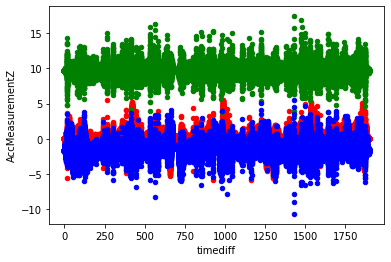

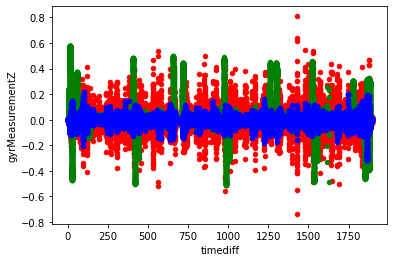

In [8]:

ax1 = imu_df.plot(kind='scatter', x='timediff', y='AccMeasurementX', color='r')    
ax2 = imu_df.plot(kind='scatter', x='timediff', y='AccMeasurementY', color='g', ax=ax1)    
ax3 = imu_df.plot(kind='scatter', x='timediff', y='AccMeasurementZ', color='b', ax=ax1)

print(ax1 == ax2 == ax3)  # True

ax4 = imu_df.plot(kind='scatter', x='timediff', y='gyrMeasurementX', color='r')    
ax5 = imu_df.plot(kind='scatter', x='timediff', y='gyrMeasurementY', color='g', ax=ax4)    
ax6 = imu_df.plot(kind='scatter', x='timediff', y='gyrMeasurementZ', color='b', ax=ax4)

print(ax4 == ax5 == ax6)  # True

In [9]:
imu_df.loc[imu_df['AccMeasurementX'] < -5]

,utcTimeMillis,AccMeasurementX,AccMeasurementY,AccMeasurementZ,gyrMeasurementX,gyrMeasurementY,gyrMeasurementZ,origintime,timediff
1965,1626727778630,-5.523831,8.709874,-0.927219,0.141869,0.007483,-0.101401,1626727759449,19.181
5431,1626727819603,-5.163113,8.572885,-1.632503,-0.002443,0.270300,-0.008857,1626727759449,60.154
32482,1626728339435,-5.103891,7.344769,-4.051647,-0.131790,0.004429,-0.098957,1626727759449,579.986
36495,1626728417883,-5.088337,8.992826,0.740579,0.016340,0.457066,-0.128278,1626727759449,658.434
36496,1626728417902,-5.103891,9.845867,-0.671785,0.131485,0.492801,-0.102317,1626727759449,658.453
36501,1626728418000,-5.349753,9.266804,0.057428,0.008552,0.472338,-0.137899,1626727759449,658.551
36503,1626728418039,-5.034499,10.312468,-1.177867,0.086740,0.474934,-0.135150,1626727759449,658.590
36511,1626728418196,-5.012963,10.132407,-0.733400,-0.014508,0.476614,-0.107051,1626727759449,658.747
42054,1626728478594,-5.059025,12.412767,-2.065604,0.221432,0.405755,0.024128,1626727759449,719.145
42074,1626728478984,-5.269594,8.583653,-1.424328,-0.072233,0.325582,-0.070247,1626727759449,719.535


In [10]:
# def tws(df, length):
# df['ts'] = pd.to_datetime(df['ts'])
# interval =[0]
# df1 = df
# for i in range(1,len(df1)):
#     interval.append(((df1.loc[i, 'ts']-df1.loc[i-1, 'ts']).days * 24 * 60 +(df1.loc[i, 'ts']-df1.loc[i-1, 'ts']).seconds)/60)
# df1['time_interval']= interval

# start = pd.to_datetime('2017-01-01 2:00:00')
# TWS = []
# ave = 0
# for i in range(1, len(df1)+1):
#     try:
#         if  df1.loc[i, 'ts']<= (start+timedelta(minutes = length)):
#             ave = ave+df1.loc[i, 'value']*df1.loc[i,'time_interval']


#         else:
#             TWS.append(ave/length)
#             ave = df1.loc[i, 'value']*df1.loc[i,'time_interval']
#             start = df1.loc[i-1,'ts']
#     except  :
#         TWS.append(ave/length)

# return TWS

# tws(df,1/60)

In [11]:
imu_df['utcTimeMillis'] = pd.to_datetime(imu_df['utcTimeMillis'])

In [12]:
imu_df['origintime'] = imu_df['utcTimeMillis'][1]

In [13]:
imu_df['timediff'] = (imu_df['utcTimeMillis'] - imu_df['origintime'])/1000

In [14]:
AG_df = imu_df.groupby('timediff').mean()

In [15]:
gnss_df

,MessageType,utcTimeMillis,TimeNanos,LeapSecond,FullBiasNanos,BiasNanos,BiasUncertaintyNanos,DriftNanosPerSecond,DriftUncertaintyNanosPerSecond,HardwareClockDiscontinuityCount,...,SvVelocityYEcefMetersPerSecond,SvVelocityZEcefMetersPerSecond,SvClockBiasMeters,SvClockDriftMetersPerSecond,IsrbMeters,IonosphericDelayMeters,TroposphericDelayMeters,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters
0,Raw,1626727759438,64107031000000,18,-1310698870407816460,0.776372,52.448038,0.613581,10.542088,1,...,1351.036860,-289.209851,-14516.554987,-0.000805,0.000000,3.778429,5.264373,-2.704222e+06,-4.288785e+06,3.856643e+06
1,Raw,1626727759438,64107031000000,18,-1310698870407816460,0.776372,52.448038,0.613581,10.542088,1,...,-426.684363,3137.821426,-49573.257469,-0.001782,0.000000,5.222988,6.289918,-2.704222e+06,-4.288785e+06,3.856643e+06
2,Raw,1626727759438,64107031000000,18,-1310698870407816460,0.776372,52.448038,0.613581,10.542088,1,...,1915.647516,2350.827939,47933.544143,0.000993,0.000000,4.411835,6.415064,-2.704222e+06,-4.288785e+06,3.856643e+06
3,Raw,1626727759438,64107031000000,18,-1310698870407816460,0.776372,52.448038,0.613581,10.542088,1,...,1144.099909,2839.238205,-40278.084579,-0.000362,0.000000,3.539628,3.990476,-2.704222e+06,-4.288785e+06,3.856643e+06
4,Raw,1626727759438,64107031000000,18,-1310698870407816460,0.776372,52.448038,0.613581,10.542088,1,...,-1604.296175,-1126.723042,-107867.343156,-0.002226,0.000000,4.337636,6.445712,-2.704222e+06,-4.288785e+06,3.856643e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67691,Raw,1626729654438,66002031000000,18,-1310698870407841663,0.533474,65.280256,2.384573,13.227319,1,...,-647.382156,-2869.352065,33740.578394,0.001816,-2344.155667,7.807055,5.109483,-2.704233e+06,-4.288809e+06,3.856651e+06
67692,Raw,1626729654438,66002031000000,18,-1310698870407841663,0.533474,65.280256,2.384573,13.227319,1,...,-2610.979613,1139.889978,-49602.703852,-0.002573,-2344.155667,9.335780,14.328397,-2.704233e+06,-4.288809e+06,3.856651e+06
67693,Raw,1626729654438,66002031000000,18,-1310698870407841663,0.533474,65.280256,2.384573,13.227319,1,...,2146.698617,1127.970745,-244889.146402,-0.002408,-2352.307876,6.854990,5.201096,-2.704233e+06,-4.288809e+06,3.856651e+06
67694,Raw,1626729654438,66002031000000,18,-1310698870407841663,0.533474,65.280256,2.384573,13.227319,1,...,-869.799322,2771.163063,-79117.488626,0.000860,-2352.307876,9.815932,6.399392,-2.704233e+06,-4.288809e+06,3.856651e+06


In [16]:
# Satellite selection using carrier frequency error, elevation angle, and C/N0
def satellite_selection(df, column):
    """
    Args:
        df : DataFrame from device_gnss.csv
        column : Column name
    Returns:
        df: DataFrame with eliminated satellite signals
    """
    idx = df[column].notnull()
    idx &= df['CarrierErrorHz'] < 2.0e6         # carrier frequency error (Hz)
    idx &= df['SvElevationDegrees'] > 10.0      # elevation angle (deg)
    idx &= df['Cn0DbHz'] > 15.0                 # C/N0 (dB-Hz)
    idx &= df['MultipathIndicator'] == 0        # Multipath flag

    return df[idx]

In [17]:
# GNSS single point positioning using pseudorange
def point_positioning(gnss_df):
    # Add nominal frequency to each signal
    # Note: GLONASS is an FDMA signal, so each satellite has a different frequency
    CarrierFrequencyHzRef = gnss_df.groupby(['Svid', 'SignalType'])[
        'CarrierFrequencyHz'].median()
    gnss_df = gnss_df.merge(CarrierFrequencyHzRef, how='left', on=[
                            'Svid', 'SignalType'], suffixes=('', 'Ref'))
    gnss_df['CarrierErrorHz'] = np.abs(
        (gnss_df['CarrierFrequencyHz'] - gnss_df['CarrierFrequencyHzRef']))

    # Carrier smoothing
    gnss_df = carrier_smoothing(gnss_df)

    # GNSS single point positioning
    utcTimeMillis = gnss_df['utcTimeMillis'].unique()
    nepoch = len(utcTimeMillis)
    x0 = np.zeros(4)  # [x,y,z,tGPSL1]
    v0 = np.zeros(4)  # [vx,vy,vz,dtGPSL1]
    x_wls = np.full([nepoch, 3], np.nan)  # For saving position
    v_wls = np.full([nepoch, 3], np.nan)  # For saving velocity

    # Loop for epochs
    for i, (t_utc, df) in enumerate(tqdm(gnss_df.groupby('utcTimeMillis'), total=nepoch)):
        # Valid satellite selection
        df_pr = satellite_selection(df, 'pr_smooth')
        df_prr = satellite_selection(df, 'PseudorangeRateMetersPerSecond')

        # Corrected pseudorange/pseudorange rate
        pr = (df_pr['pr_smooth'] + df_pr['SvClockBiasMeters'] - df_pr['IsrbMeters'] -
              df_pr['IonosphericDelayMeters'] - df_pr['TroposphericDelayMeters']).to_numpy()
        prr = (df_prr['PseudorangeRateMetersPerSecond'] +
               df_prr['SvClockDriftMetersPerSecond']).to_numpy()

        # Satellite position/velocity
        xsat_pr = df_pr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                         'SvPositionZEcefMeters']].to_numpy()
        xsat_prr = df_prr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                           'SvPositionZEcefMeters']].to_numpy()
        vsat = df_prr[['SvVelocityXEcefMetersPerSecond', 'SvVelocityYEcefMetersPerSecond',
                       'SvVelocityZEcefMetersPerSecond']].to_numpy()

        # Weight matrix for peseudorange/pseudorange rate
        Wx = np.diag(1 / df_pr['RawPseudorangeUncertaintyMeters'].to_numpy())
        Wv = np.diag(1 / df_prr['PseudorangeRateUncertaintyMetersPerSecond'].to_numpy())

        # Robust WLS requires accurate initial values for convergence,
        # so perform normal WLS for the first time
        if len(df_pr) >= 4:
            # Normal WLS
            if np.all(x0 == 0):
                opt = scipy.optimize.least_squares(
                    pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx))
                x0 = opt.x 
            # Robust WLS for position estimation
            opt = scipy.optimize.least_squares(
                 pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx), loss='soft_l1')
            if opt.status < 1 or opt.status == 2:
                 print(f'i = {i} position lsq status = {opt.status}')
            else:
                 x_wls[i, :] = opt.x[:3]
                 x0 = opt.x
                 
        # Velocity estimation
        if len(df_prr) >= 4:
            if np.all(v0 == 0): # Normal WLS
                opt = scipy.optimize.least_squares(
                    prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv))
                v0 = opt.x
            # Robust WLS for velocity estimation
            opt = scipy.optimize.least_squares(
                prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv), loss='soft_l1')
            if opt.status < 1:
                print(f'i = {i} velocity lsq status = {opt.status}')
            else:
                v_wls[i, :] = opt.x[:3]
                v0 = opt.x

    return utcTimeMillis, x_wls, v_wls, 

In [18]:
# Carrier smoothing of pseudarange
def carrier_smoothing(gnss_df):
    """
    Args:
        df : DataFrame from device_gnss.csv
    Returns:
        df: DataFrame with carrier-smoothing pseudorange 'pr_smooth'
    """
    carr_th = 1.6 # carrier phase jump threshold [m] 2->1.5 (best)->1.0
    pr_th =  20.0 # pseudorange jump threshold [m] 20->15

    prsmooth = np.full_like(gnss_df['RawPseudorangeMeters'], np.nan)
    # Loop for each signal
    for (i, (svid_sigtype, df)) in enumerate((gnss_df.groupby(['Svid', 'SignalType']))):
        df = df.replace(
            {'AccumulatedDeltaRangeMeters': {0: np.nan}})  # 0 to NaN

        # Compare time difference between pseudorange/carrier with Doppler
        drng1 = df['AccumulatedDeltaRangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']
        drng2 = df['RawPseudorangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']

        # Check cycle-slip
        slip1 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**1) != 0  # reset flag
        slip2 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**2) != 0  # cycle-slip flag
        slip3 = np.fabs(drng1.to_numpy()) > carr_th # Carrier phase jump
        slip4 = np.fabs(drng2.to_numpy()) > pr_th # Pseudorange jump

        idx_slip = slip1 | slip2 | slip3 | slip4
        idx_slip[0] = True

        # groups with continuous carrier phase tracking
        df['group_slip'] = np.cumsum(idx_slip)

        # Psudorange - carrier phase
        df['dpc'] = df['RawPseudorangeMeters'] - df['AccumulatedDeltaRangeMeters']

        # Absolute distance bias of carrier phase
        meandpc = df.groupby('group_slip')['dpc'].mean()
        df = df.merge(meandpc, on='group_slip', suffixes=('', '_Mean'))

        # Index of original gnss_df
        idx = (gnss_df['Svid'] == svid_sigtype[0]) & (
            gnss_df['SignalType'] == svid_sigtype[1])

        # Carrier phase + bias
        prsmooth[idx] = df['AccumulatedDeltaRangeMeters'] + df['dpc_Mean']

    # If carrier smoothing is not possible, use original pseudorange
    idx_nan = np.isnan(prsmooth)
    prsmooth[idx_nan] = gnss_df['RawPseudorangeMeters'][idx_nan]
    gnss_df['pr_smooth'] = prsmooth

    return gnss_df

In [19]:
# Compute line-of-sight vector from user to satellite
def los_vector(xusr, xsat):
    """
    Args:
        xusr : user position in ECEF (m)
        xsat : satellite position in ECEF (m)
    Returns:
        u: unit line-of-sight vector in ECEF (m)
        rng: distance between user and satellite (m)
    """
    u = xsat - xusr
    rng = np.linalg.norm(u, axis=1).reshape(-1, 1)
    u /= rng
    
    return u, rng.reshape(-1)


# Compute Jacobian matrix
def jac_pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(pr), 1])])  # J = [-ux -uy -uz 1]

    return W @ J


# Compute pseudorange residuals
def pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange residuals
    """
    u, rng = los_vector(x[:3], xsat)

    # Approximate correction of the earth rotation (Sagnac effect) often used in GNSS positioning
    rng += OMGE * (xsat[:, 0] * x[1] - xsat[:, 1] * x[0]) / CLIGHT

    # Add GPS L1 clock offset
    residuals = rng - (pr - x[3])

    return residuals @ W


# Compute Jacobian matrix
def jac_prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(prr), 1])])

    return np.dot(W, J)


# Compute pseudorange rate residuals
def prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange rate residuals
    """
    u, rng = los_vector(x[:3], xsat)
    rate = np.sum((vsat-v[:3])*u, axis=1) \
          + OMGE / CLIGHT * (vsat[:, 1] * x[0] + xsat[:, 1] * v[0]
                           - vsat[:, 0] * x[1] - xsat[:, 0] * v[1])

    residuals = rate - (prr - v[3])

    return residuals @ W

In [20]:
# Simple outlier detection and interpolation
def exclude_interpolate_outlier(x_wls, v_wls):
    # Up velocity threshold
    v_up_th = 2.0 # m/s

    # Coordinate conversion
    x_llh = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
    v_enu = np.array(pm.ecef2enuv(
        v_wls[:, 0], v_wls[:, 1], v_wls[:, 2], x_llh[0, 0], x_llh[0, 1])).T

    # Up velocity jump detection
    # Cars don't jump suddenly!
    idx_v_out = np.abs(v_enu[:, 2]) > v_up_th
    v_wls[idx_v_out, :] = np.nan
    
    # Interpolate NaNs at beginning and end of array
    x_df = pd.DataFrame({'x': x_wls[:, 0], 'y': x_wls[:, 1], 'z': x_wls[:, 2]})
    x_df = x_df.interpolate(limit_area='outside', limit_direction='both')
    
    # Interpolate all NaN data
    v_df = pd.DataFrame({'x': v_wls[:, 0], 'y': v_wls[:, 1], 'z': v_wls[:, 2]})
    v_df = v_df.interpolate(limit_area='outside', limit_direction='both')
    v_df = v_df.interpolate('spline', order=3)

    return x_df.to_numpy(), v_df.to_numpy()

In [21]:
# Point positioning
utc, x_wls, v_wls = point_positioning(gnss_df)

# Exclude velocity outliers
x_wls, v_wls = exclude_interpolate_outlier(x_wls, v_wls)


  0%|          | 0/1896 [00:00<?, ?it/s]

In [22]:
V_df = pd.DataFrame(v_wls , columns = ['V_X', 'V_Y', 'V_Z'])

In [23]:
X_df = pd.DataFrame(x_wls , columns = ['P_X', 'P_Y', 'P_Z'])

In [24]:
final_df = pd.concat([V_df, X_df, AG_df.reset_index().drop('timediff', axis = 1)], axis = 1)

In [25]:
final_df

,V_X,V_Y,V_Z,P_X,P_Y,P_Z,AccMeasurementX,AccMeasurementY,AccMeasurementZ,gyrMeasurementX,gyrMeasurementY,gyrMeasurementZ
0,0.002427,0.009412,-0.085312,-2.704219e+06,-4.288784e+06,3.856641e+06,0.046326,9.675666,-1.673072,-0.000018,-0.000229,-0.000834
1,-0.034383,-0.025428,0.099216,-2.704224e+06,-4.288791e+06,3.856639e+06,0.047101,9.674710,-1.663244,0.000098,-0.000329,-0.001047
2,-0.014704,-0.005804,-0.039698,-2.704233e+06,-4.288800e+06,3.856645e+06,0.047454,9.676812,-1.661661,-0.000047,-0.000293,-0.000777
3,-0.012309,0.014406,-0.081689,-2.704232e+06,-4.288799e+06,3.856642e+06,0.049128,9.675704,-1.658133,-0.000142,-0.000350,-0.000780
4,-0.046198,-0.059728,0.011678,-2.704233e+06,-4.288804e+06,3.856645e+06,0.054542,9.669044,-1.660091,-0.001479,-0.001740,0.001120
...,...,...,...,...,...,...,...,...,...,...,...,...
1891,0.003131,0.037035,0.011521,-2.704211e+06,-4.288785e+06,3.856624e+06,0.025029,9.685261,-1.663837,-0.000302,-0.000113,-0.000452
1892,0.036123,0.134389,-0.032736,-2.704214e+06,-4.288787e+06,3.856631e+06,0.024204,9.687348,-1.664565,-0.000772,-0.000253,-0.000335
1893,-0.054016,0.014386,0.124155,-2.704209e+06,-4.288779e+06,3.856624e+06,0.025949,9.687447,-1.666938,-0.000034,-0.000087,-0.000338
1894,0.054397,0.058969,-0.096175,-2.704210e+06,-4.288781e+06,3.856625e+06,0.024329,9.684566,-1.665451,-0.000271,-0.000062,-0.000362


In [85]:
a = pd.concat([final_df,gt_df[['LatitudeDegrees' , 'LongitudeDegrees']]], axis = 1)

In [63]:
# def convert_wgs_to_utm(lon, lat):
#     utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
#     if len(utm_band) == 1:
#         utm_band = '0'+utm_band
#     if lat >= 0:
#         epsg_code = '326' + utm_band
#     else:
#         epsg_code = '327' + utm_band
#     return epsg_code


# utm_code = convert_wgs_to_utm(a['LongitudeDegrees'].mean(), a['LatitudeDegrees'].mean())
# crs_wgs = proj.Proj(init='epsg:4326') # assuming using WGS84
# crs_utm = proj.Proj(init='epsg:{0}'.format(utm_code))
# x, y = np.multiply(proj.transform(crs_wgs, crs_utm, a['LongitudeDegrees'], a['LatitudeDegrees']),0.001)

In [64]:
# a['gt_x'] = x
# a['gt_y'] = y
# a['gt_z'] = a['P_Z']

In [86]:
a

,V_X,V_Y,V_Z,P_X,P_Y,P_Z,AccMeasurementX,AccMeasurementY,AccMeasurementZ,gyrMeasurementX,gyrMeasurementY,gyrMeasurementZ,LatitudeDegrees,LongitudeDegrees
0,0.002427,0.009412,-0.085312,-2.704219e+06,-4.288784e+06,3.856641e+06,0.046326,9.675666,-1.673072,-0.000018,-0.000229,-0.000834,37.444105,-122.232767
1,-0.034383,-0.025428,0.099216,-2.704224e+06,-4.288791e+06,3.856639e+06,0.047101,9.674710,-1.663244,0.000098,-0.000329,-0.001047,37.444105,-122.232767
2,-0.014704,-0.005804,-0.039698,-2.704233e+06,-4.288800e+06,3.856645e+06,0.047454,9.676812,-1.661661,-0.000047,-0.000293,-0.000777,37.444106,-122.232767
3,-0.012309,0.014406,-0.081689,-2.704232e+06,-4.288799e+06,3.856642e+06,0.049128,9.675704,-1.658133,-0.000142,-0.000350,-0.000780,37.444106,-122.232767
4,-0.046198,-0.059728,0.011678,-2.704233e+06,-4.288804e+06,3.856645e+06,0.054542,9.669044,-1.660091,-0.001479,-0.001740,0.001120,37.444106,-122.232767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891,0.003131,0.037035,0.011521,-2.704211e+06,-4.288785e+06,3.856624e+06,0.025029,9.685261,-1.663837,-0.000302,-0.000113,-0.000452,37.444102,-122.232774
1892,0.036123,0.134389,-0.032736,-2.704214e+06,-4.288787e+06,3.856631e+06,0.024204,9.687348,-1.664565,-0.000772,-0.000253,-0.000335,37.444102,-122.232774
1893,-0.054016,0.014386,0.124155,-2.704209e+06,-4.288779e+06,3.856624e+06,0.025949,9.687447,-1.666938,-0.000034,-0.000087,-0.000338,37.444103,-122.232774
1894,0.054397,0.058969,-0.096175,-2.704210e+06,-4.288781e+06,3.856625e+06,0.024329,9.684566,-1.665451,-0.000271,-0.000062,-0.000362,37.444103,-122.232774


In [87]:
sc = MinMaxScaler(feature_range=(-1,1))
x_data = np.array(a.drop(['LatitudeDegrees'	,'LongitudeDegrees'],axis = 1))
y_data = np.array(a[['LatitudeDegrees'	,'LongitudeDegrees']])
new_x_data = sc.fit_transform(x_data)
new_x_data = new_x_data.reshape(new_x_data.shape[0],new_x_data.shape[1],1)
new_y_data = y_data

print('X_data shape :', x_data.shape)
print('new X_data shape :', new_x_data.shape)
print('y_data shape :', y_data.shape)
print('new y_data shape :', new_y_data.shape)

X_data shape : (1896, 12)
new X_data shape : (1896, 12, 1)
y_data shape : (1896, 2)
new y_data shape : (1896, 2)


In [88]:
model = Sequential()

model.add(LSTM(units=20, batch_input_shape=(None,new_x_data.shape[1],1),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=10,return_sequences=False))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(units=2))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 12, 20)            1760      
_________________________________________________________________
lstm_14 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_29 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_33 (Dense)             (None, 2)                

In [89]:
history = model.fit(new_x_data,new_y_data,epochs=50, verbose=2)

Epoch 1/50
60/60 - 7s - loss: 7020.1128 - accuracy: 1.0000
Epoch 2/50
60/60 - 1s - loss: 207.9585 - accuracy: 1.0000
Epoch 3/50
60/60 - 1s - loss: 0.7471 - accuracy: 1.0000
Epoch 4/50
60/60 - 1s - loss: 0.0464 - accuracy: 1.0000
Epoch 5/50
60/60 - 1s - loss: 0.0350 - accuracy: 1.0000
Epoch 6/50
60/60 - 1s - loss: 0.0334 - accuracy: 1.0000
Epoch 7/50
60/60 - 1s - loss: 0.0323 - accuracy: 1.0000
Epoch 8/50
60/60 - 1s - loss: 0.0307 - accuracy: 1.0000
Epoch 9/50
60/60 - 1s - loss: 0.0292 - accuracy: 1.0000
Epoch 10/50
60/60 - 1s - loss: 0.0279 - accuracy: 1.0000
Epoch 11/50
60/60 - 2s - loss: 0.0270 - accuracy: 1.0000
Epoch 12/50
60/60 - 2s - loss: 0.0251 - accuracy: 1.0000
Epoch 13/50
60/60 - 2s - loss: 0.0238 - accuracy: 1.0000
Epoch 14/50
60/60 - 2s - loss: 0.0225 - accuracy: 1.0000
Epoch 15/50
60/60 - 2s - loss: 0.0210 - accuracy: 1.0000
Epoch 16/50
60/60 - 2s - loss: 0.0200 - accuracy: 1.0000
Epoch 17/50
60/60 - 2s - loss: 0.0187 - accuracy: 1.0000
Epoch 18/50
60/60 - 2s - loss: 0.01

In [90]:
pred = model.predict(new_x_data)

### Neural Network is making predictions worse than smoothing

In [99]:
all_tracks = pd.concat([pd.DataFrame(pred, columns = ['LatitudeDegrees' , 'LongitudeDegrees']), gt_df[['LatitudeDegrees' , 'LongitudeDegrees']]])
all_tracks  =all_tracks[['LatitudeDegrees' , 'LongitudeDegrees']]
all_tracks['Name'] = np.repeat(['pred','gt'],gt_df.shape[0])

fig = px.line_mapbox(all_tracks, lat='LatitudeDegrees', lon='LongitudeDegrees',
                     color="Name", labels="Name",
                        zoom=12, center={"lat":37.45, "lon":-122.27}, 
                        height=600, width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()